# 초기 세팅

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


- 현재 GPU 설정

In [3]:
# colab의 runtime-type을 GPU로 설정해서, True가 나오도록 한다.

torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # gpu('cuda')가 사용가능하면, gpu를 이용하도록 설정
device

device(type='cuda')

# CIFAR10 분류 모델
* R/G/B(3) 이미지 데이터 분류
* 32x32 pixel

## 전처리 설정

In [5]:
# transform 정의

CIFAR_transform = transforms.Compose([transforms.ToTensor(), # tensor로 펴준다.
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # r,g,b 데이터임으로, 3개의 인자값 전달

## 데이터 로드 및 확인

In [6]:
# datasets

trainset = torchvision.datasets.CIFAR10(root='/content',
                                 train=True, download=True,
                                 transform=CIFAR_transform)

testset = torchvision.datasets.CIFAR10(root='/content',
                                 train=False, download=True,
                                 transform=CIFAR_transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [7]:
# DataLoader

# batch-size = 4

train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

test_loader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [8]:
# 숫자 label에 해당되는 값

class_list = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

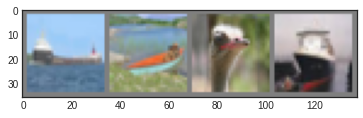

ship	 ship	 bird	 ship	


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('{}\t'.format(class_list[labels[j]]) for j in range(4)))

## 모델 생성

* input size = 4 * 3 * 32 * 32
* output size = 4 * 10
* 모델 조건
> * convolution-layer : 2개 이상 사용
> * maxpooling-layer : 1개 이상 사용
> * fc-layer : 2개 이상 사용
> * activation-function 으로 'relu' 사용

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )

        self.linear_block1 = nn.Sequential(
            nn.Linear(256*8*8, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5)
        )

        self.linear_block2 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(256,10)
        )

        self.pool = nn.MaxPool2d(kernel_size = 2)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.pool(x)
        #x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.pool(x)
        x = x.view(-1, self.num_flat_features(x)) 
        x = self.linear_block1(x)
        x = self.linear_block2(x)

        return x
    
    def num_flat_features(self, x): 
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        
        return num_features

In [52]:
myNet = Net().to(device) # gpu에 모델 저장
myNet

Net(
  (conv_block1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (linear_block1): Sequential(
    (0): Linear(in_features=16384, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (linear_block2): Sequential(
    (0): Linear(in_featu

In [53]:
# input; (4 * 3 * 32 * 32)

input = images.to(device)
input.size()

torch.Size([4, 3, 32, 32])

In [54]:
# output; (4 * 10)

output = myNet.forward(input)
output.size()

torch.Size([4, 10])

In [55]:
# 모델 구조 확인

summary(myNet, input_size=(3, 32, 32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [4, 128, 32, 32]           9,728
       BatchNorm2d-2           [4, 128, 32, 32]             256
              ReLU-3           [4, 128, 32, 32]               0
            Conv2d-4           [4, 256, 32, 32]         295,168
       BatchNorm2d-5           [4, 256, 32, 32]             512
              ReLU-6           [4, 256, 32, 32]               0
         MaxPool2d-7           [4, 256, 16, 16]               0
            Conv2d-8           [4, 256, 16, 16]         590,080
       BatchNorm2d-9           [4, 256, 16, 16]             512
             ReLU-10           [4, 256, 16, 16]               0
        MaxPool2d-11             [4, 256, 8, 8]               0
           Linear-12                  [4, 1024]      16,778,240
      BatchNorm1d-13                  [4, 1024]           2,048
             ReLU-14                  [

## 손실함수와 옵티마이저

In [56]:
criterion = nn.CrossEntropyLoss() # 다중분류; CrossEntropyLoss
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9) # SGD; lr=0.001 & momentum=0.9

## 모델 학습

In [57]:
# epochs = 10

for epoch in range(10):
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()       
        
        outputs = myNet(inputs)                            
        loss = criterion(outputs, labels)                            
        loss.backward()                            
        optimizer.step()                            

        running_loss += loss.item()
        if i % 2000 == 1999:
            print("Epoch: {}, Batch: {}, Loss: {}".format(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0

Epoch: 1, Batch: 2000, Loss: 1.9980520351827145
Epoch: 1, Batch: 4000, Loss: 1.8139954482614995
Epoch: 1, Batch: 6000, Loss: 1.7455712790340185
Epoch: 1, Batch: 8000, Loss: 1.6439825355112552
Epoch: 1, Batch: 10000, Loss: 1.5661086981594563
Epoch: 1, Batch: 12000, Loss: 1.5324481884092092
Epoch: 2, Batch: 2000, Loss: 1.463571293503046
Epoch: 2, Batch: 4000, Loss: 1.4147591785788536
Epoch: 2, Batch: 6000, Loss: 1.415111791998148
Epoch: 2, Batch: 8000, Loss: 1.397467180080712
Epoch: 2, Batch: 10000, Loss: 1.3608902796804905
Epoch: 2, Batch: 12000, Loss: 1.3191555929556489
Epoch: 3, Batch: 2000, Loss: 1.2994746217206121
Epoch: 3, Batch: 4000, Loss: 1.294500234544277
Epoch: 3, Batch: 6000, Loss: 1.2790943769291043
Epoch: 3, Batch: 8000, Loss: 1.2539928176030517
Epoch: 3, Batch: 10000, Loss: 1.2514334848821163
Epoch: 3, Batch: 12000, Loss: 1.238914028160274
Epoch: 4, Batch: 2000, Loss: 1.1829110005758703
Epoch: 4, Batch: 4000, Loss: 1.1979826106652618
Epoch: 4, Batch: 6000, Loss: 1.18662679

## 모델의 저장 및 로드

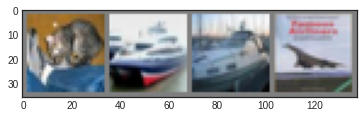

	cat 	ship 	ship 	plane


In [58]:
# 잘 학습된 모델인지 간단히 한 batch에 대해서 확인

dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join('\t{}'.format(class_list[labels[j]]) for j in range(4))) # batch-size = 4

In [59]:
# 저장

PATH = './cifar_net.pth'
torch.save(myNet.state_dict(), PATH)

In [60]:
# 불러오기

Loaded_Net = Net().to(device)
Loaded_Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 모델 테스트
* 조건
> 전체 accuracy가 70% 이상이어야한다.<br>
> 각각의 class에 대한 accuracy는 60% 이상이어야한다.

In [61]:
# 전체 accuracy 확인; 70% 이상 성능값

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)                                              
        outputs = myNet(images)                                              
        _, predicted = torch.max(outputs.data, axis=1)  # 확률이 가장 큰 것의 label을 최종 예측값으로 선택
        total += labels.size(0) # 전체 갯수
        correct += (predicted == labels).sum().item()   # 맞춘 갯수
    
    print(100 * correct / total)

67.66


- 어떤 것을 잘 분류했고, 잘 못했는지 확인

In [62]:
# 각각의 class에 대한 accuracy 확인; 각각의 class에 대한 60% 이상 성능값

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = Loaded_Net(images)
        _, predicted = torch.max(outputs.data, axis=1)
        c = (predicted == labels).squeeze()
        for i in range(4): # 각각의 batch(batch-size : 4) 마다 계싼
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print("Accuracy of {}: {}%".format(class_list[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 70.6%
Accuracy of car: 79.6%
Accuracy of bird: 49.6%
Accuracy of cat: 42.2%
Accuracy of deer: 64.2%
Accuracy of dog: 56.4%
Accuracy of frog: 75.1%
Accuracy of horse: 72.9%
Accuracy of ship: 81.2%
Accuracy of truck: 77.0%
